# CS 6140 Machine Learning: Assignment - 3 (Total Points: 100)
## Prof. Ahmad Uzair 

## Q1. Answer the following questions. (20 Points)

1. Why SVM is an example of large margin classifier?
2. What role does C play in SVM?
3. What is the purpose of kernels in SVM?
4. Is it possible to use kernels in logistic regression? Why isn’t this a common practice?

Answer:

1. According to the lecture note, "A support vector machine (SVM) constructs a hyperplane or set of hyperplanes in a high- or infinite- dimensional space, which can be used for classification, regression, or other tasks", The SVM attempts to find a hyperplane that has the largest distance to the nearest training data point of any class (called functional margin). Therefore, the SVM is an example of large margin classifier.


2. We have soft margin $min_{w, b} \frac{1}{2} ||w_n||^2 + C \sum_{i=1}^N \xi_i$. We use slack variables $\xi_i$ that transform the constraints to soft constraints, allowing instances to have a margin that is leass than 1. However, for violationg the constraint we pay a linear penalty. For a constraint violation we pay a penalty of $C\xi_i$. The role for C is to control the trade-off between maximizing the margin (minimizing $||w_n||^2$) and ensuring that all instances have a margin of 1.


3. A kennel function defines the inner product between two instances in a higher (possibly infinite) dimensional space. We can, therefore, relace the inner product in the dual objective with any valid kernel function. For SVM, prediction depends only on their inner product with support vectors, using the kernel trick we can replace the inner product with the same kernel function that we used for training.


4. The kernel function compute the pairwise similarity between data points in the new feature space but for cost function of logistic regression which is using log likelihood, it may not easy to transform and solve by using kernels. 

## Q2. Implement Support Vector Machines (SVMs) from scratch, for the classification of non- linearly separable data. (30 Points)

Hint : You can use minimize() of scipy.optimize for optimization.
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

1. Generate non-linearly separable data. (You can refer to the code snippet given below:)

In [1]:
# Create data class ClusterX.
# Create data class ClusterY.
# To get the input data, combine the classes ClusterX and ClusterY.
# For each training data point, set the labels/target data. Label 1 corresponds to class A, while label -1 
# corresponds to class B.
# Rearrange the data and labels at random (same random ordering).
import numpy as np
import random
np.random.seed(105)
ClusterX = np.concatenate((np.random.randn(10, 2) * 0.4 + [1.5, -0.5], 
                         np.random.randn(10, 2) * 0.4 + [-1.5, 0.5]))
ClusterY = np.random.randn(20, 2) * 0.3 + [0.0, -0.9]
input_data = np.concatenate((ClusterX, ClusterY))
target_data = np.concatenate((np.ones(ClusterX.shape[0]), -np.ones(ClusterY.shape[0])))
size = input_data.shape[0]
shuffle_data = list(range(size))
random.shuffle(shuffle_data)
input_data = input_data[shuffle_data, :]
target_data = target_data[shuffle_data]

2. Perform data visualization on the above generated data.

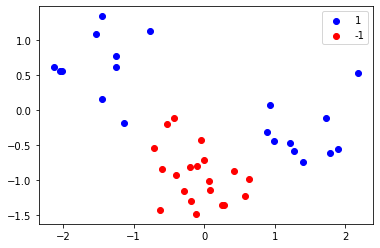

In [2]:
import matplotlib.pyplot as plt
plt.scatter(input_data[target_data == 1, 0], input_data[target_data == 1, 1], c='b', label='1')
plt.scatter(input_data[target_data == -1, 0], input_data[target_data == -1, 1], c='r', label='-1')
plt.legend()
plt.show()

3. a. Implement SVM with linear kernel. Explain why training the linear kernel model without C would fail?
b. Optimize training of the linear model using C.

Answer: As our data visualization shown above, our dataset is not linear separable so if we don't use C as our regularization constant which means using hard margin classifier, it would be fail since we could not separate these data by using linear classification, in other words the hard margin classifier won't work dur to the inequality constraint $y_i (w^T x_i + 1) \geq 1$. For solve this problem, we will use C which is a constants to balances the cost of misclassification. If C $\rightarrow 0$, maximize the margin (loss is zero); Otherwis C $\rightarrow \infty$, minimize the loss (margin doesn't have effect). After optimize using C which means we build soft margin classifier, it would be allowed some missclassified points.

In [3]:
class SVM:
    def __init__(self, kernel='linear', n_epoch=100, C=1.0, eta=0.001, degree=3, sig=0.5): 
        if kernel == 'poly':
            self.kernel = self.polynomial_kernel
            self.degree = degree
        elif kernel == 'rbf':
            self.kernel = self.rbf_kernel
            self.sigma = sig
        else:
            self.kernel = self.linear_kernel
            
        self.n_epoch = n_epoch         # number of iteration
        self.C = C                     # balances the cost of misclassification (regularization constant)
        self.eta = eta                 # learning rate
        self.b = 0                     # bias
    
    def linear_kernel(self, x1, x2):
        # k(x, z) = x.T * z
        return x1.dot(x2.T) + self.C
        
    def polynomial_kernel(self, x1, x2):
        # k(x, z) = (x.T * z)^m
        return (x1.dot(x2.T) + self.C) ** self.degree
    
    def rbf_kernel(self, x1, x2):
        # gassian kernel: k(x, z) = exp(- ||x-z||^2 / 2sigmma^2), rbf kernel: k(x, z) = exp(-1/sigma^2 ||x-z||^2)
        #return np.exp(-(np.linalg.norm(x1[:, np.newaxis] - x2[np.newaxis, :], axis=2) ** 2) / (2 * self.sigma ** 2))
        return np.exp(-(1 / self.sigma ** 2) * np.linalg.norm(x1[:, np.newaxis] - x2[np.newaxis, :], axis=2) ** 2)
   
    def fit(self, X, y):
        self.X, self.y = X, y
        n, d = X.shape
        self.a = np.random.random(n)        # alpha
        ones = np.ones(n)
        l = list()
        
        # max_a L_dual(a) =  max_a{sum{i=1}^n ai - 1/2sum{i=1}^n sum{j=1}^n ai * aj * yi * yj * k(xi, xj)}
        
        # yi * yj * xi.T * xj
        # >= 1, ai = 0; = 1, 0 < ai < c; <= 1, ai = c
        yi_yj_kij = np.outer(y, y) * self.kernel(X, X)
        
        for epoch in range(self.n_epoch):
            # < 0, ai = 0; > 0, ai = c
            gradient = ones - yi_yj_kij.dot(self.a)
            self.a = self.a + self.eta * gradient
            self.a[self.a > self.C] = self.C
            self.a[self.a < 0] = 0 
            
            # L(w, b, a) = sum{i=1}^m ai - 0.5 sum{i, j=1}^m (ai * aj * yi * yj * xi.T * xj)
            l.append(np.sum(self.a) - 0.5 * np.sum(np.outer(self.a, self.a) * yi_yj_kij))
            
        i = np.where((self.a > 0) & (self.a < self.C))[0]  # index of misclassified
        # updat bias
        # b* = yi - sum{i=1}^n ai* * yi * k(xi, xj)
        b_temp = y[i] - (self.a * y).dot(self.kernel(X, X[i]))
        self.b = np.mean(b_temp)
        
    def decision_function(self, X):
        # w* = sum{i} ai* * yi * xi
        # sum{i=1}^n ai* * yi(x * xi) + b*
        return (self.a * self.y).dot(self.kernel(self.X, X)) + self.b
    
    def predict(self, X):
        # if > 0 return 1 else return -1
        return np.sign(self.decision_function(X))
    
    def accuracy(self, X, y):
        return np.mean(y == self.predict(X))
    
    def visualize_decision_boundary(self):
        # data visualization
        plt.scatter(self.X[self.y == 1, 0], self.X[self.y == 1, 1], c='b', label='1')
        plt.scatter(self.X[self.y == -1, 0], self.X[self.y == -1, 1], c='r', label='-1')
        plt.legend()
        # plot the decision function
        ax = plt.gca()
        xlim, ylim = ax.get_xlim(), ax.get_ylim()
        
        # create grid to evaluate model
        xx, yy = np.linspace(xlim[0], xlim[1], 30), np.linspace(ylim[0], ylim[1], 30)
        #xx, yy = np.linspace(-2, 2), np.linspace(-2, 2)
        YY, XX = np.meshgrid(yy, xx)
        xy = np.vstack([XX.ravel(), YY.ravel()]).T
        z = self.decision_function(xy).reshape(XX.shape)

        # plot decision boundary and margins
        ax.contour(XX, YY, z, colors='k', levels=[-1,0,1],alpha=0.5,linestyles=['--','-','--'])
        # plot support vectors
        ax.scatter(self.X[:, 0][self.a > 0], self.X[:, 1][self.a > 0], s=50, linewidth=1, facecolors='none', edgecolors='k')
        plt.show()

In [4]:
linear_svm = SVM()

In [5]:
linear_svm.fit(input_data, target_data)

In [6]:
acc1 = linear_svm.accuracy(input_data, target_data)
print("Accuracy of linaer kernel:", acc1)

Accuracy of linaer kernel: 0.925


4. Perform data visualization with decision boundary.

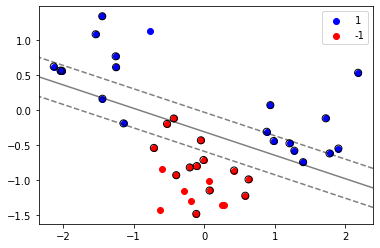

In [7]:
linear_svm.visualize_decision_boundary()

5. Implement SVM with polynomial kernel.

In [8]:
poly_svm = SVM(kernel='poly')

In [9]:
poly_svm.fit(input_data, target_data)

In [10]:
acc2 = poly_svm.accuracy(input_data, target_data)
print("Accuracy of polynomial kernel:", acc2)

Accuracy of polynomial kernel: 1.0


6. Compare the results of decision boundaries of linear and polynomial kernels using data visualization.

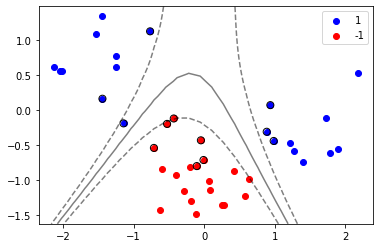

In [11]:
poly_svm.visualize_decision_boundary()

According to the data visualization, we can see polynomial kernel did better than linear kernel

## Q3. Compare the results of SVMs with polynomial kernels and Radial Basis Function (RBF) kernel (50 Points)

1. Generate non-linearly separable data using code snippet given below.

In [12]:
from sklearn import datasets
input_data, target_data = datasets.make_circles(n_samples=40, factor=0.5, noise=0.05)
target_data[target_data == 0] = -1

ClusterX = input_data[target_data == 1]
ClusterY = input_data[target_data == -1]

In [13]:
input_data = np.concatenate((ClusterX, ClusterY))
target_data = np.concatenate((np.ones(ClusterX.shape[0]), -np.ones(ClusterY.shape[0])))
size = input_data.shape[0]
shuffle_data = list(range(size))
random.shuffle(shuffle_data)
input_data = input_data[shuffle_data, :]
target_data = target_data[shuffle_data]

2. Perform data visualization on the above generated data.

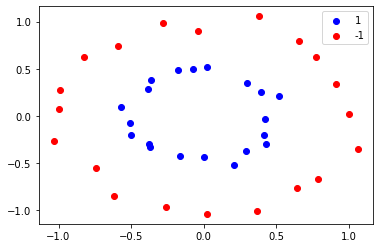

In [14]:
import matplotlib.pyplot as plt
plt.scatter(ClusterX[:, 0],ClusterX[:, 1],c='b',label='1')
plt.scatter(ClusterY[:, 0],ClusterY[:, 1],c='r',label='-1')
plt.legend()

3. Implement SVM with polynomial kernel. Make use of C to perform optimization.

In [15]:
poly_svm = SVM(kernel='poly', eta=0.01)
poly_svm.fit(input_data, target_data)
acc2 = poly_svm.accuracy(input_data, target_data)
print("Accuracy of polynomial kernel:", acc2)

Accuracy of polynomial kernel: 1.0


4. Perform data visualization with decision boundary.

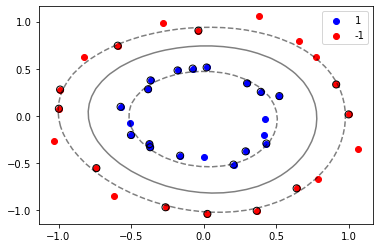

In [16]:
poly_svm.visualize_decision_boundary()

5. Implement SVM with RBF (Radial Basis Function) kernel.

In [17]:
rbf_svm = SVM(kernel='rbf', eta=0.01)
rbf_svm.fit(input_data, target_data)
acc3 = poly_svm.accuracy(input_data, target_data)
print("Accuracy of rbf kernel:", acc3)

Accuracy of rbf kernel: 1.0


6. Compare the results of decision boundaries of polynomial and RBF kernels using data visualization.

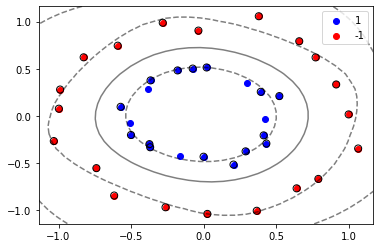

In [18]:
rbf_svm.visualize_decision_boundary()

According to the decision boundary by data visualization, we could find that polynomial kernel and RBF kernel both did good job on this dataset.